# Project 16 - Convolutional Neural Project Cats and Dogs

## Step 1 - Libraries

In [7]:
!pip install torchviz tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 10.7 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 10.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 8.7 MB/s eta 0:00:000:00:010:00:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 4.8 MB/s eta 0:00:00 MB/s eta 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [23]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import zipfile
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


## Step 2 - Model Building

In [3]:
classifier = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
                            nn.ReLU(),
                            nn.BatchNorm2d(num_features=32),
                            nn.MaxPool2d(kernel_size=2),
                            nn.Conv2d(32, 32, 3),
                            nn.ReLU(),
                            nn.BatchNorm2d(32),
                            nn.MaxPool2d(2),
                            nn.Flatten(),
                            nn.Linear(in_features=14*14*32, out_features=128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128, 128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128, 1),
                            nn.Sigmoid())

In [10]:
x = torch.randn(1, 3, 64, 64)

writer = SummaryWriter()

writer.add_graph(classifier, x)
writer.close()

In [11]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.17.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


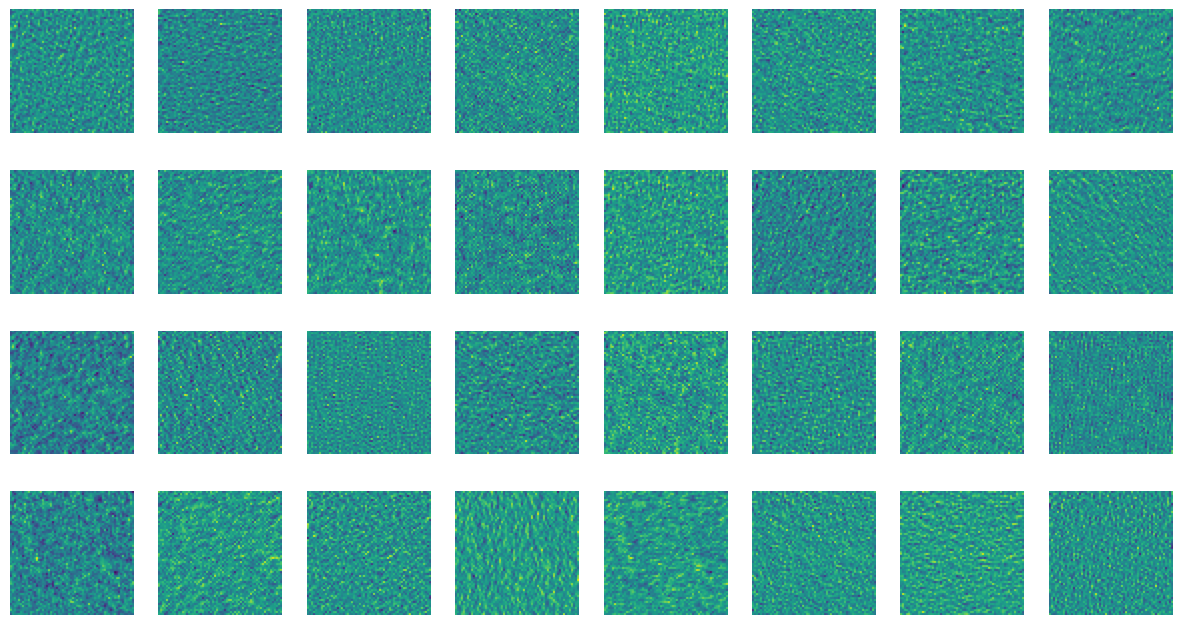

In [14]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

classifier[0].register_forward_hook(get_activation('conv1'))

y = classifier(x)

act = activations['conv1'].squeeze().cpu()

fig, axs = plt.subplots(4, 8, figsize=(15, 8))
for i, ax in enumerate(axs.flat):
    if i < act.size(0):
        ax.imshow(act[i], cmap='viridis')
        ax.axis('off')
plt.show()

In [4]:
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters())

In [24]:
path = 'Datasets/dataset.zip'

zip_obj = zipfile.ZipFile(path, 'r')
zip_obj.extractall('Datasets/')
zip_obj.close()

In [25]:
data_dir_train = 'Datasets/dataset/training_set'
data_dir_test = 'Datasets/dataset/test_set'

In [26]:
transform_train = transforms.Compose(
    [
        transforms.Resize([64, 64]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=7, translate=(0, 0.07), shear=0.2, scale=(1, 1.2)),
        transforms.ToTensor()
    ]
)

In [27]:
transform_test = transforms.Compose(
    [
        transforms.Resize([64, 64]),
        transforms.ToTensor()
    ]
)

In [28]:
train_dataset = datasets.ImageFolder(data_dir_train, transform=transform_train)

In [29]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 4000
    Root location: Datasets/dataset/training_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-7.0, 7.0], translate=(0, 0.07), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           )

In [30]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [31]:
test_dataset = datasets.ImageFolder(data_dir_test, transform=transform_test)

In [32]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: Datasets/dataset/test_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

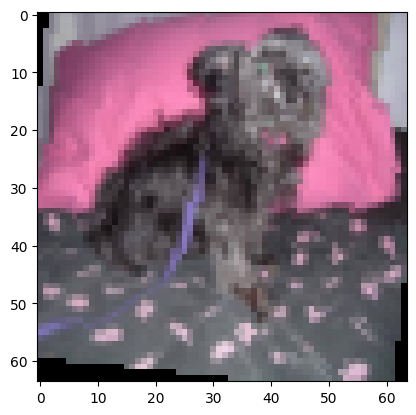

In [44]:
img, label = train_dataset[0]

plt.imshow(img.permute(1, 2, 0))

In [33]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = classifier.to(device)

In [35]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(inputs)

        loss = criterion(outputs, labels.float().view(*outputs.shape))
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)

        equals = predicted == labels.view(*predicted.shape)

        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy

        print(f'Epoch {epoch + 1} - Loss: {loss} - Accuracy: {accuracy}')
    
    print(f'Epoch {epoch + 1} - Loss: {running_loss / len(loader)} - Accuracy: {running_accuracy / len(loader)}')

In [37]:
for epoch in range(10):
    print('Training...')
    training_loop(train_loader, epoch)

    classifier.eval()
    print('Evaluating...')

    training_loop(test_loader, epoch)
    classifier.train()

Training...
Epoch 1 - Loss: 0.4305969476699829 - Accuracy: 0.8125
Epoch 1 - Loss: 0.5054739713668823 - Accuracy: 0.75
Epoch 1 - Loss: 0.5992808938026428 - Accuracy: 0.75
Epoch 1 - Loss: 0.8662509918212891 - Accuracy: 0.5625
Epoch 1 - Loss: 0.6070255041122437 - Accuracy: 0.5625
Epoch 1 - Loss: 0.5665298700332642 - Accuracy: 0.78125
Epoch 1 - Loss: 0.7301563024520874 - Accuracy: 0.65625
Epoch 1 - Loss: 0.5005120038986206 - Accuracy: 0.78125
Epoch 1 - Loss: 0.5897768139839172 - Accuracy: 0.65625
Epoch 1 - Loss: 0.5327874422073364 - Accuracy: 0.84375
Epoch 1 - Loss: 0.5974277257919312 - Accuracy: 0.71875
Epoch 1 - Loss: 0.434689998626709 - Accuracy: 0.78125
Epoch 1 - Loss: 0.5090291500091553 - Accuracy: 0.71875
Epoch 1 - Loss: 0.43385955691337585 - Accuracy: 0.875
Epoch 1 - Loss: 0.4737398326396942 - Accuracy: 0.75
Epoch 1 - Loss: 0.3274705410003662 - Accuracy: 0.90625
Epoch 1 - Loss: 0.598569929599762 - Accuracy: 0.6875
Epoch 1 - Loss: 0.5631552934646606 - Accuracy: 0.75
Epoch 1 - Loss: 0

In [38]:
torch.save(classifier.state_dict(), 'classifier.pth')

In [70]:
def image_classify(fname):

    from PIL import Image
    import matplotlib.pyplot as plt

    test_image = Image.open(data_dir_test + '/' + fname)
    plt.imshow(test_image)

    import numpy as np
    test_image = test_image.convert("RGB")
    test_image = test_image.resize((64,64))
    test_image = np.array(test_image.getdata()).reshape(*test_image.size, 3)
    test_image = test_image / 255
    test_image = test_image.transpose(2, 0, 1)
    test_image = torch.tensor(test_image, dtype=torch.float).view(-1, *test_image.shape)

    classifier.eval()
    test_image = test_image.to(device)

    output = classifier.forward(test_image)

    if output > 0.5:
        output = 1
    else:
        output = 0

    print('Forecast: ', output)

    idx_to_class = {value:key for key, value in test_dataset.class_to_idx.items()}

    return idx_to_class[output]

Forecast:  0


'cachorro'

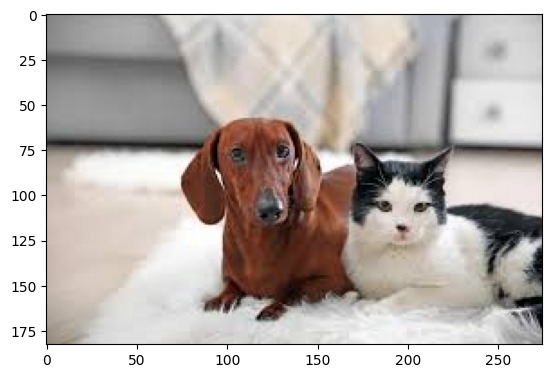

In [78]:
image = '/cachorro/dog.4003.jpg'
image_classify(image)

Forecast:  0


'cachorro'

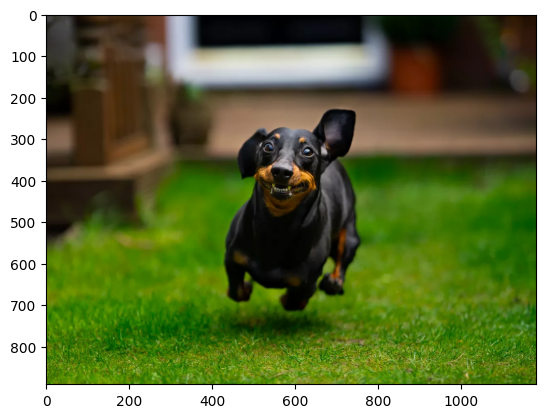

In [62]:
image = '/cachorro/dog.4001.jpg'
image_classify(image)